In [67]:
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import Sequential
from keras.src.layers import LSTM, Dropout, Dense, GRU
from keras.src.losses import MeanSquaredError, MeanAbsoluteError
from keras.src.metrics import RootMeanSquaredError
from keras.src.optimizers import Adam

from metrics import ExplainedVarianceScore
import matplotlib.pyplot as plt

keras.utils.set_random_seed(0)

In [57]:
print(f'Num gpus available: {len(tf.config.list_physical_devices("GPU"))}')

Num gpus available: 0


In [58]:
df = pd.read_csv('RV1_SIPIA_preprocessed.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)

In [59]:
df.head(10)

,diff_PM10,PM2.5_squared,PM2.5,roll_mean_PM10_7d,cum_count_high_NO2,diff_PM2.5,dew_point_2m (°C),PM10
Date,,,,,,,,
2023-02-15 19:00:00+00:00,-0.066964,0.768199,0.876470,2.163226,1,0.016728,0.208497,2.247076
2023-02-15 20:00:00+00:00,-0.066964,0.797803,0.893198,2.163226,2,0.016728,0.205579,2.180111
2023-02-15 20:00:00+00:00,0.000000,0.797803,0.893198,2.163226,3,0.000000,0.205579,2.180111
2023-02-15 21:00:00+00:00,-0.143066,0.780228,0.883305,2.163226,4,-0.009893,0.205579,2.037045
2023-02-15 21:00:00+00:00,0.000000,0.780228,0.883305,2.163226,5,0.000000,0.205579,2.037045
2023-02-15 22:00:00+00:00,0.193552,0.842175,0.917701,2.163226,6,0.034396,0.173654,2.230597
2023-02-15 22:00:00+00:00,0.000000,0.842175,0.917701,2.163226,7,0.000000,0.173654,2.230597
2023-02-15 23:00:00+00:00,-0.193552,0.792005,0.889947,2.133222,8,-0.027755,0.170766,2.037045
2023-02-15 23:00:00+00:00,0.000000,0.792005,0.889947,2.112784,9,0.000000,0.170766,2.037045


In [60]:
df.describe()

,diff_PM10,PM2.5_squared,PM2.5,roll_mean_PM10_7d,cum_count_high_NO2,diff_PM2.5,dew_point_2m (°C),PM10
count,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000
mean,-0.000258,0.220307,0.410996,0.000602,724.163022,-0.000039,0.544101,0.000000
std,0.291043,0.195854,0.226713,0.950964,290.288695,0.054352,0.232600,1.000089
min,-2.313248,0.000000,0.000000,-2.338911,1.000000,-0.467692,0.000000,-2.338911
25%,-0.107611,0.062847,0.250692,-0.708376,640.000000,-0.013880,0.353677,-0.706489
50%,0.000000,0.181266,0.425753,0.018244,725.000000,0.000000,0.602072,0.020638
75%,0.114477,0.319716,0.565434,0.644836,900.000000,0.016575,0.742465,0.693280
max,2.761979,1.000000,1.000000,2.711811,1383.000000,0.375968,1.000000,2.994063


In [61]:
def createSlidingWinwows(df, windowSize, stepSize=1):
    windows = []
    for start in range(0, len(df) - windowSize + 1, stepSize):
        end = start + windowSize
        window = df.iloc[start:end]
        windows.append(window)
    return windows

In [62]:
def trainTestSplit(windows, target, trainSize=0.8):
    train = windows[:int(len(windows) * trainSize)]
    test = windows[int(len(windows) * trainSize):]
    
    Xtrain = np.array([window.drop(columns=[target]).values for window in train])
    yTrain = np.array([window[target].values for window in train])

    Xtest = np.array([window.drop(columns=[target]).values for window in test])
    yTest = np.array([window[target].values for window in test])
    
    return Xtrain, yTrain, Xtest, yTest

In [63]:
windows = createSlidingWinwows(df, 21)
Xtrain, yTrain, Xtest, yTest = trainTestSplit(windows, 'PM10')

In [64]:
print(f'Xtrain shape: {Xtrain.shape}')
print(f'yTrain shape: {yTrain.shape}')
print(f'Xtest shape: {Xtest.shape}')
print(f'yTest shape: {yTest.shape}')

Xtrain shape: (4484, 21, 7)
yTrain shape: (4484, 21)
Xtest shape: (1121, 21, 7)
yTest shape: (1121, 21)


In [65]:
lstm = Sequential()
lstm.add(LSTM(100, input_shape=(21, 7), return_sequences=True)) # return_sequences=True if stacking LSTM layers
lstm.add(Dropout(0.3))
lstm.add(LSTM(50))
lstm.add(Dropout(0.3))
lstm.add(Dense(50, activation='relu'))
lstm.add(Dense(21))

lstm.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='mean_squared_error',
    metrics=[
        MeanSquaredError(),
        MeanAbsoluteError(),
        RootMeanSquaredError(),
        ExplainedVarianceScore()
    ]
)

lstmHistory = lstm.fit(
    Xtrain, yTrain,
    epochs=100,
    batch_size=32,
    validation_data=(Xtest, yTest),
    verbose=1,
)

Epoch 1/100
141/141 [==============================] - ETA: 0s - loss: 0.7627 - mean_squared_error: 0.7611 - mean_absolute_error: 0.7009 - root_mean_squared_error: 0.8733 - explained_variance_score: 0.1904

D:\Projects\rirsu-rnn\venv\Lib\site-packages\keras\src\engine\training.py:2723: UserWarning: Metric ExplainedVarianceScore implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


141/141 [==============================] - 6s 20ms/step - loss: 0.7627 - mean_squared_error: 0.7611 - mean_absolute_error: 0.7009 - root_mean_squared_error: 0.8733 - explained_variance_score: 0.1904 - val_loss: 1.3049 - val_mean_squared_error: 1.3319 - val_mean_absolute_error: 0.9790 - val_root_mean_squared_error: 1.1423 - val_explained_variance_score: 1.3921
Epoch 2/100
141/141 [==============================] - 2s 18ms/step - loss: 0.5049 - mean_squared_error: 0.5039 - mean_absolute_error: 0.5542 - root_mean_squared_error: 0.7106 - explained_variance_score: 0.4563 - val_loss: 0.4887 - val_mean_squared_error: 0.5024 - val_mean_absolute_error: 0.5632 - val_root_mean_squared_error: 0.6991 - val_explained_variance_score: 0.3318
Epoch 3/100
141/141 [==============================] - 2s 16ms/step - loss: 0.2234 - mean_squared_error: 0.2227 - mean_absolute_error: 0.3535 - root_mean_squared_error: 0.4727 - explained_variance_score: 0.7631 - val_loss: 0.3533 - val_mean_squared_error: 0.3634 -

In [66]:
gru = Sequential()
gru.add(GRU(100, input_shape=(21, 7), return_sequences=True))  # 21 time steps, 7 features
gru.add(Dropout(0.3))
gru.add(GRU(50))
gru.add(Dropout(0.3))
gru.add(Dense(50, activation='relu'))
gru.add(Dense(21))

gru.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='mean_squared_error',
    metrics=[
        MeanSquaredError(),
        MeanAbsoluteError(),
        RootMeanSquaredError(),
        ExplainedVarianceScore()
    ]
)

gruHistory = gru.fit(
    Xtrain, yTrain,
    epochs=100,
    batch_size=32,
    validation_data=(Xtest, yTest),
    verbose=1,
)

Epoch 1/100
141/141 [==============================] - 6s 20ms/step - loss: 0.7852 - mean_squared_error: 0.7820 - mean_absolute_error: 0.7121 - root_mean_squared_error: 0.8861 - explained_variance_score: 0.1974 - val_loss: 1.7444 - val_mean_squared_error: 1.7917 - val_mean_absolute_error: 1.0963 - val_root_mean_squared_error: 1.3207 - val_explained_variance_score: 2.2055
Epoch 2/100
141/141 [==============================] - 2s 15ms/step - loss: 0.4276 - mean_squared_error: 0.4260 - mean_absolute_error: 0.5017 - root_mean_squared_error: 0.6539 - explained_variance_score: 0.5535 - val_loss: 0.4329 - val_mean_squared_error: 0.4488 - val_mean_absolute_error: 0.5152 - val_root_mean_squared_error: 0.6579 - val_explained_variance_score: 0.2510
Epoch 3/100
141/141 [==============================] - 2s 16ms/step - loss: 0.2386 - mean_squared_error: 0.2380 - mean_absolute_error: 0.3677 - root_mean_squared_error: 0.4885 - explained_variance_score: 0.7497 - val_loss: 0.3477 - val_mean_squared_err

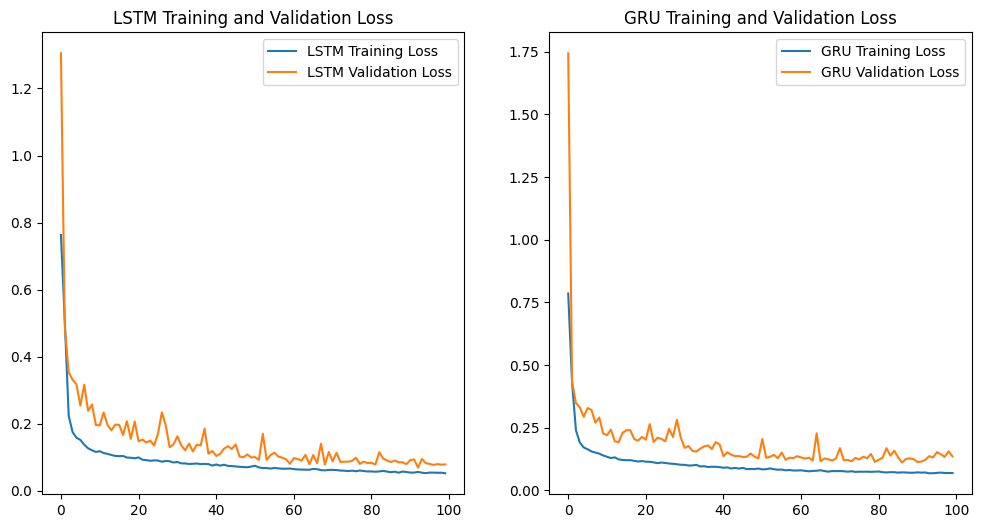

In [68]:
plt.figure(figsize=(12, 6))

# LSTM Losses
plt.subplot(1, 2, 1)
plt.plot(lstmHistory.history['loss'], label='LSTM Training Loss')
plt.plot(lstmHistory.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()

# GRU Losses
plt.subplot(1, 2, 2)
plt.plot(gruHistory.history['loss'], label='GRU Training Loss')
plt.plot(gruHistory.history['val_loss'], label='GRU Validation Loss')
plt.title('GRU Training and Validation Loss')
plt.legend()

plt.show()